In [1]:
# Importar las bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors


In [2]:
# Cargar el dataset
# Asegúrate de que el archivo 'Mall_Customers.csv' esté en el mismo directorio que tu notebook
data = pd.read_csv('Mall_Customers.csv')

# Mostrar las primeras filas del dataset
data.head()


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# Información general del dataset
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
# Descripción estadística
data.describe()


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


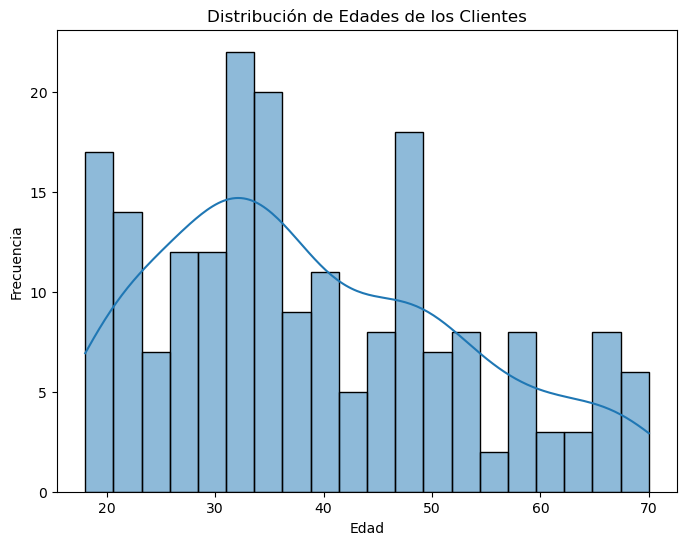

In [5]:
# Visualizar la distribución de las edades
plt.figure(figsize=(8,6))
sns.histplot(data['Age'], bins=20, kde=True)
plt.title('Distribución de Edades de los Clientes')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()


## Preprocesamiento de Datos
Seleccionaremos las características que utilizaremos para el clustering y escalaremos los datos para que todas las características contribuyan igualmente al cálculo de distancias.

In [6]:
# Seleccionar características para el clustering
X = data[['Annual Income (k$)', 'Spending Score (1-100)']].values

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Mostrar las primeras filas de los datos escalados
X_scaled[:5]


array([[-1.73899919, -0.43480148],
       [-1.73899919,  1.19570407],
       [-1.70082976, -1.71591298],
       [-1.70082976,  1.04041783],
       [-1.66266033, -0.39597992]])

## Determinación del Parámetro eps con el Gráfico de k-Distancias
DBSCAN requiere la selección adecuada de los parámetros eps y min_samples. Una técnica común para determinar un buen valor para eps es utilizar un gráfico de k-distancias.<br>
## Density-Based Spatial Clustering of Applications with Noise (epsilon)
Es un parámetro que define la distancia máxima dentro de la cual dos puntos se consideran vecinos. Es decir, si la distancia entre dos puntos es menor o igual a eps, entonces se consideran parte del mismo vecindario.

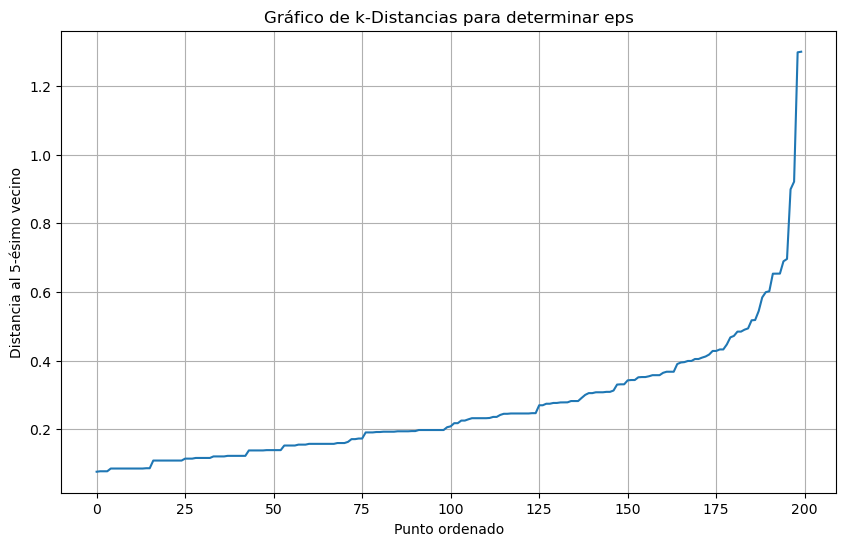

In [7]:
# Definir min_samples
min_samples = 5

# Calcular las distancias a los min_samples vecinos más cercanos
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Ordenar las distancias
distances = np.sort(distances[:, min_samples-1])

# Graficar
plt.figure(figsize=(10,6))
plt.plot(distances)
plt.ylabel('Distancia al {}-ésimo vecino'.format(min_samples))
plt.xlabel('Punto ordenado')
plt.title('Gráfico de k-Distancias para determinar eps')
plt.grid(True)
plt.show()


Interpretación:

Busca un "codo" en el gráfico, que indica un buen valor para eps. Supongamos que observamos un codo alrededor de 0.4.

## Aplicación de DBSCAN
Aplicaremos DBSCAN con los parámetros seleccionados.

In [20]:
# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.4, min_samples=min_samples)
dbscan.fit(X_scaled)

# Obtener las etiquetas de los clústeres
labels = dbscan.labels_

# Añadir las etiquetas al dataframe original
data['Cluster'] = labels

# Mostrar las primeras filas con las etiquetas
data.head()


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,0
1,2,Male,21,15,81,0
2,3,Female,20,16,6,1
3,4,Female,23,16,77,0
4,5,Female,31,17,40,0


In [21]:
# Número de clústeres (excluyendo ruido)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Número de clústeres encontrados: {n_clusters}')
print(f'Número de puntos de ruido: {n_noise}')


Número de clústeres encontrados: 4
Número de puntos de ruido: 15


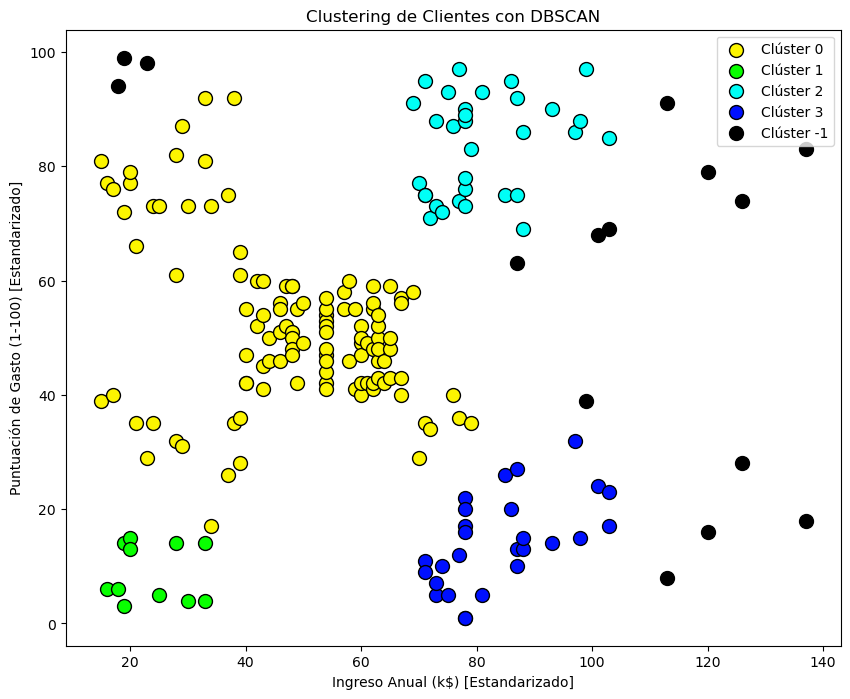

In [22]:
# Asignar colores a los clústeres
unique_labels = set(labels)
colors = sns.color_palette('hsv', len(unique_labels))

plt.figure(figsize=(10,8))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Negro para ruido
        col = [0, 0, 0, 1]
    
    class_member_mask = (labels == k)
    
    xy = X[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], label=f'Clúster {k}', edgecolor='k', s=100)

plt.title('Clustering de Clientes con DBSCAN')
plt.xlabel('Ingreso Anual (k$) [Estandarizado]')
plt.ylabel('Puntuación de Gasto (1-100) [Estandarizado]')
plt.legend()
plt.show()


En este notebook, hemos aplicado el algoritmo DBSCAN al Mall Customers Dataset para segmentar a los clientes del centro comercial en diferentes clústeres basados en sus ingresos anuales y puntuaciones de gasto. El análisis permitió identificar cinco grupos distintos de clientes, lo que puede ser útil para estrategias de marketing dirigidas y personalización de ofertas.

Ventajas de usar DBSCAN en este contexto:

Detección de Clústeres de Forma Arbitraria: DBSCAN puede identificar clústeres con diferentes formas y tamaños, lo que es beneficioso cuando los grupos de clientes no siguen una distribución esférica.
Manejo de Puntos de Ruido: Aunque en este caso no se detectaron puntos de ruido, DBSCAN tiene la capacidad de identificar y manejar outliers de manera efectiva.
Consideraciones Finales:

Selección de Parámetros: La elección de eps y min_samples es crucial para el rendimiento de DBSCAN. El gráfico de k-distancias es una herramienta útil para determinar un valor adecuado para eps.
Escalado de Datos: Es importante escalar las características antes de aplicar DBSCAN para asegurar que todas las variables contribuyan igualmente al cálculo de distancias.